Ce notebook sert à afficher des graphiques qui résument les outputs de l'inférence sur `Parcours_1` avec les différents algorithmes.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
#sns.set()

# Données

## Importation des données

In [2]:
def import_outputs(path, panoptic=False):
    df = pd.read_json(path, orient='index')
    df.index = df.index.astype(int)
    if panoptic:
        df['pred_classes'] = df.apply(lambda row: [elem['category_id'] for elem in row if elem is not None], axis=1)
        df = df.filter(['pred_classes'])
    else:
        df.drop('scores', axis=1, inplace=True)
    return df

In [3]:
faster = import_outputs('../inference/faster_rcnn/Parcours_1_1hz/outputs.json')
mask = import_outputs('../inference/mask_rcnn/Parcours_1_1hz/outputs.json')
panoptic = import_outputs('../inference/panoptic_fpn/Parcours_1_1hz/outputs.json', True)

Labels :

In [4]:
from pycocotools.coco import COCO
dataDir = '../datasets/coco'
dataType = 'val2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco = COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
labels = [cat['name'] for cat in cats]

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


## Création d'un unique dataframe

In [5]:
classes = pd.concat([faster['pred_classes'].rename('faster'),
                     mask['pred_classes'].rename('mask'), 
                     panoptic['pred_classes'].rename('panoptic')], axis=1)

In [6]:
def count_classes(preds, name, label_max=80):
    counts = {k: 0 for k in range(label_max)}
    for _, pred in preds.iteritems():
        for p in pred:
            counts[p] += 1
    return pd.DataFrame.from_dict(counts, orient='index', columns=[name])

In [12]:
counts = pd.concat([count_classes(faster['pred_classes'], 'faster'),
                    count_classes(mask['pred_classes'], 'mask'),
                    count_classes(panoptic['pred_classes'], 'panoptic')], axis=1)
counts.index = labels
# counts = counts.iloc[np.argsort(-counts.sum(axis=1)), :]  # sort the dataframe
counts = counts.iloc[np.argsort(-counts['faster']), :]  # sort the dataframe
counts.head()

,faster,mask,panoptic
car,1331,1364,1274
bicycle,1095,1186,937
person,507,493,447
bench,296,283,312
chair,189,185,206


# Affichage

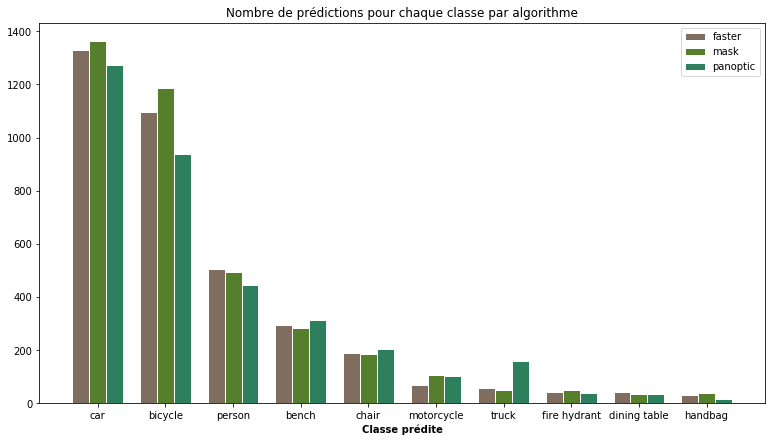

In [17]:
lim = 10
barWidth = 0.25

fig = plt.figure(figsize=(lim+3,7))
ax = plt.gca()
 
# Set position of bar on X axis
x1 = np.arange(lim)
x2 = [x + barWidth for x in x1]
x3 = [x + barWidth for x in x2]
 
# Make the plot
ax.bar(x1, counts[:lim]['faster'], color='#7f6d5f', width=barWidth, edgecolor='white', label='faster')
ax.bar(x2, counts[:lim]['mask'], color='#557f2d', width=barWidth, edgecolor='white', label='mask')
ax.bar(x3, counts[:lim]['panoptic'], color='#2d7f5e', width=barWidth, edgecolor='white', label='panoptic')
 
# Add xticks on the middle of the group bars
ax.set_xlabel('Classe prédite', fontweight='bold')
plt.xticks([r + barWidth for r in range(lim)], counts.index[:lim].to_numpy())
 
# Create legend & Show graphic
ax.legend()
ax.set_title('Nombre de prédictions pour chaque classe par algorithme')
fig.show()